In [7]:
from cmath import nan
from PIL import Image
import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt
import os, glob
from PIL import Image
import cv2
import pandas as pd

In [8]:
"""
image registration and cropping functions
"""
def align_to_standard(img_dir, src_dir='src.jpeg'):
    src_color = cv2.imread(src_dir)
    sbj_color = cv2.imread(img_dir)

    src = cv2.cvtColor(src_color, cv2.COLOR_BGR2GRAY)
    sbj = cv2.cvtColor(sbj_color, cv2.COLOR_BGR2GRAY)
    
    orb_detector = cv2.ORB_create(2000)
    src_keypoints, src_descriptors = orb_detector.detectAndCompute(src, None)
    sbj_keypoints, sbj_descriptors = orb_detector.detectAndCompute(sbj,None)

    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)
    matches = list(matcher.match(sbj_descriptors, src_descriptors))
    
    matches.sort(key = lambda x: x.distance)
    matches = matches[:int(len(matches)*0.9)]
    # records matched keypoints' coordinates
    no_of_matches = len(matches)
    p1 = np.zeros((no_of_matches, 2))
    p2 = np.zeros((no_of_matches, 2))

    for i in range(no_of_matches):
        p1[i, :] = sbj_keypoints[matches[i].queryIdx].pt
        p2[i, :] = src_keypoints[matches[i].trainIdx].pt
    
    homography, mask = cv2.findHomography(p1, p2, cv2.RANSAC)
    transformed_img = cv2.warpPerspective(sbj_color,
                        homography, (src.shape[1], src.shape[0]))
    return transformed_img

def crop_rotate_dir(img, og_file_dir, output_dir, angle = -1.5, left = 135, upper =85, right = 600, lower = 390):
    filename = og_file_dir.split('/')[-1]
    im = Image.fromarray(img)
    rotated = im.rotate(angle, expand = 1)
    im_final = rotated.crop((left, upper, right, lower))            
    im_final.save(output_dir+'/'+filename)

In [15]:
"""
input: filename of plate
output: pd df of the ground truth for that plate
"""
from typing import Tuple

all_labels = pd.read_csv('updated_ground_truth.csv')

def get_ground_truth(filename: str):
    id = filename.split('_')[-1].split('.')[0]
    this_labels = all_labels.loc[all_labels["destination_plate_bcode"]==int(id),['destination_well']].to_numpy()
    return this_labels
    
"""
return ngs data delivery success for all wells in this plate; type = pandas df
"""
all_labels_w_ngs = pd.read_csv('updated_ground_truth_ngs.csv')
def get_ground_truth_w_ngs(filename: str):
    id = filename.split('_')[-1].split('.')[0]
    successes = all_labels_w_ngs.loc[all_labels_w_ngs["destination_plate_bcode"]==int(id), ['ngs_data_delivery_success', 'destination_well']]
    return successes

"""
gaussian_kernel_size: greater = blurring in larger neighborhood
gaussian_sigma: greater sigma = more blurring
adp_th_block_size needs to be odd: greater = looking at local intensities in a larger neighborhood
adp_th_const is a constant that is subtracted from the weighted mean; greater = effectively more noise reduction
"""
def load_and_preprocess_img(filename: str, gaussian_kernel_size: Tuple = (3,3), adapt=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, thresh=cv2.THRESH_BINARY_INV, gaussian_sigma: float = 1.0, adp_th_block_size: int = 5, adp_th_const: int = 4):
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    img_blurred = cv2.GaussianBlur(img, gaussian_kernel_size, gaussian_sigma)
    img_th = cv2.adaptiveThreshold(img_blurred, 255, adapt, thresh, adp_th_block_size, adp_th_const)
    return img_th

"""
exclude wells with black background
"""
def exclude_wells(col_idx, row_idx):
    # M3, M4, A12, A13, P12, P13, C21
    if ((col_idx == 2 or col_idx == 3) and row_idx == 12) or ((row_idx ==0 or row_idx == 15) and (col_idx==11 or col_idx ==12)) or (row_idx == 2 and col_idx==20):
        return True
    return False
"""
input: img or preprocessed img
output: conceptually a matrix of 16 x 24, each entry is the isolated well image
"""
def isolate_each_well(img_th):
    to_return = []
    y = img_th.shape[0] / 16
    x = img_th.shape[1] / 24
    for row in np.arange(0, img_th.shape[0], y):
        col_out = []
        for col in np.arange(0, img_th.shape[1], x):
            col_out.append(img_th[round(row):round(row+y),round(col):round(col+x)])
        to_return.append(col_out)
    return np.array(to_return, dtype=object)

"""
If one and only one particle is detected, report 1
If no particle detected, report 0
else: report -1 to indicate ambiguity
"""
def particle_detection_prediction(well_img):
    nb_components, arr = cv2.connectedComponents(well_img, connectivity=8)
    if nb_components - 1 == 1:
        pred = 1
    elif nb_components - 1 == 0:
        pred = 0
    else:
        pred = -1
    return pred

In [32]:
"""
Uses particle detection to predict whether or not bead is present.
Returns accuracy and a list of unsure well locations for each img (if particle_detection_prediction returns -1)
    which means that more than one particle is detected in the well
"""
from numpy import isnan
from collections import defaultdict

def melodys_pipeline(thresh, adapt, block, c, k, registration, input_dir = '../second_batch_img/', cropped_output_dir = '../cropped_second_batch_img/'):
    # save aligned and cropped imgs to disk to avoid taking up too much memory
    # if registration:
    #     cropped_output_dir = 'cropped2/'
    # for filename in glob.glob(input_dir+'/*.jpg'):
    #     # print(filename)
    #     if registration:
    #         img = align_to_standard(filename)
    #     else:
    #         img = cv2.imread(filename)
    #     crop_rotate_dir(img, filename, output_dir=cropped_output_dir,left = 135, upper =85, right = 600, lower = 390)

    accuracy_list = []
    with_label = []
    no_label = []
    y_true, y_pred = [], []
    failed_bc_dispense = 0
    failed_not_dc_dispense = 0
    ngs_success_counter = 0
    ngs_failed_counter = 0
    true_false_neg_counter = 0
    ngs_nan = 0
    # wells = defaultdict(lambda:0)
    # totals = defaultdict(lambda:0)
    # specials = defaultdict(lambda:0)
    # unsure_dict = {}
    # read every image file from the input folder
    for filename in glob.glob(cropped_output_dir +'/*.jpg'):
        print(filename)
        right = 0
        wrong = 0
        unsure = []
        labels = get_ground_truth(filename)
        if len(labels) == 0:
            no_label.append(filename)
            continue
        with_label.append(filename)

        ngs_successes_df = get_ground_truth_w_ngs(filename)

        img_th = load_and_preprocess_img(filename=filename, gaussian_kernel_size=(3,3), thresh=thresh, adapt=adapt, adp_th_block_size=block, adp_th_const=c, gaussian_sigma=1.0)
        # print(type(img_th))
        well_imgs = isolate_each_well(img_th)
        for row in range(well_imgs.shape[0]):
            for col in range(well_imgs.shape[1]):
                if exclude_wells(col, row):
                    continue
                
                # crop out a kxk square in the center of the well
                well = np.array(well_imgs[row,col])
                if well.shape[1] == 20:
                    well = well[:, :-1]
                row_diff = (well.shape[0] - k) // 2
                well = well[row_diff:, :]
                well = well[:k, :]
                well = well[:, row_diff:]
                well = well[:, :k]
                
                # pred = particle_detection_prediction(well) # comment this if using only num of val in thresholded img and uncomment the following line
                pred = len(np.unique(well)) - 1 

                #generate well id for df lookup
                well_id = chr(ord('A') + row) + str(col + 1)

                # get ngs success for this well
                ngs_success = ngs_successes_df.loc[ngs_successes_df['destination_well'] == well_id,['ngs_data_delivery_success']].to_numpy().flatten()
                if len(ngs_success) == 0 or ngs_success[0] == nan:
                    ngs_success = nan
                else:
                    ngs_success = ngs_success[0]
                #count ngs success
                if ngs_success == True:
                    ngs_success_counter += 1
                elif ngs_success == False:
                    ngs_failed_counter += 1
                else:
                    ngs_nan += 1

                if pred != -1:
                    y_pred.append(pred)

                    #get truth
                    # totals[well_id] += 1
                    if well_id in labels:
                        truth = 1
                    else:
                        truth = 0
                    # if well_id in ['A11', 'A14'] and truth == 1:
                    #     specials[well_id] += 1
                    # elif well_id in ['P11', 'P14'] and truth == 1:
                    #     specials[well_id] += 1
                    y_true.append(truth)   
                    if pred == truth:
                        # wells[well_id] += 1
                        right += 1

                        if pred == 1 and ngs_success == False: # if definitely have beads but ngs not successful
                            failed_not_dc_dispense += 1

                    else:
                        wrong += 1
                        if pred == 0 and truth == 1: # if false negative, check if ngs delivery failed
                            if ngs_success == False: # if ngs delivery failed
                                # y_true[-1] = 0
                                failed_bc_dispense += 1
                            elif ngs_success == True: # if ngs delivery successful then it must mean that there are beads
                                true_false_neg_counter += 1
                else:
                    unsure.append([row, col])
        accuracy_list.append(right / (right + wrong + len(unsure)))
        # unsure_dict[filename] = len(unsure)
    # print("unsure: ", unsure)
    # return accuracy_list, y_true, y_pred, wells, totals, specials, with_label, no_label, true_false_neg_counter, failed_bc_dispense/ngs_failed_counter, failed_not_dc_dispense/ngs_failed_counter, ngs_success_counter, ngs_failed_counter, ngs_nan #, unsure_dict
    return accuracy_list, y_true, y_pred, with_label, no_label, true_false_neg_counter, failed_bc_dispense/ngs_failed_counter, failed_not_dc_dispense/ngs_failed_counter, ngs_success_counter, ngs_failed_counter, ngs_nan #, unsure_dict
    # return None
    # return None

../cropped_second_batch_img/220201_170607_879184.jpg
../cropped_second_batch_img/220118_130215_869669.jpg
../cropped_second_batch_img/220215_144028_887739.jpg
../cropped_second_batch_img/220324_121939_908873.jpg
../cropped_second_batch_img/220223_173011_893157.jpg
../cropped_second_batch_img/220413_101822_920196.jpg
../cropped_second_batch_img/220811_133759_994235.jpg
../cropped_second_batch_img/220926_131430_1025332.jpg
../cropped_second_batch_img/220615_125359_955396.jpg
../cropped_second_batch_img/220510_131556_934454.jpg
../cropped_second_batch_img/220913_131611_1016725.jpg
../cropped_second_batch_img/220525_140033_943133.jpg
../cropped_second_batch_img/221004_130811_1031282.jpg
../cropped_second_batch_img/220425_132629_926220.jpg
../cropped_second_batch_img/220427_130311_927662.jpg
../cropped_second_batch_img/220628_141336_963610.jpg
../cropped_second_batch_img/220823_141109_1000749.jpg
../cropped_second_batch_img/221024_131511_1046898.jpg
../cropped_second_batch_img/220629_131928

(array([   2.,    0.,    2.,    0.,    8.,    4.,   16.,   21.,   52.,
        1106.]),
 array([0.16710875, 0.25039788, 0.333687  , 0.41697613, 0.50026525,
        0.58355438, 0.6668435 , 0.75013263, 0.83342175, 0.91671088,
        1.        ]),
 <BarContainer object of 10 artists>)

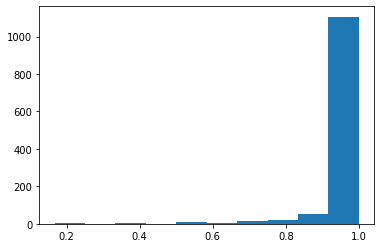

In [33]:
accs, _, _, _, _, true_false_neg_counter, failed_bc_dispense, failed_not_dc_dispense, ngs_success_counter, ngs_failed_counter, ngs_nan = melodys_pipeline(cv2.THRESH_BINARY, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 5, 4, k=9, registration=False)
print(np.mean(accs))
plt.hist(accs)

In [34]:
print(true_false_neg_counter, failed_bc_dispense, failed_not_dc_dispense, ngs_success_counter, ngs_failed_counter, ngs_nan)

5800 0.04010115606936416 0.9598988439306358 220793 74736 161018


In [37]:
ngs_nan/(ngs_success_counter + ngs_failed_counter + ngs_nan)

0.35268657991400665